In [2]:
# Import libraries. 
# Generate images in the notebook
%matplotlib inline

import matplotlib.pyplot as plt
import collections
from collections import defaultdict
import gzip
import itertools
import numpy as np
import os
import time
import pandas as pd
import seaborn as sns

import bokeh
import bokeh.io
from bokeh.io import push_notebook
from bokeh.plotting import figure, show, save, output_notebook, output_file

# Import colour palettes for later on
from bokeh.palettes import Category20b
from bokeh.palettes import Purples
from bokeh.palettes import Greens
from bokeh.palettes import YlOrBr
from bokeh.palettes import YlOrRd
from bokeh.palettes import PuOr
from bokeh.palettes import RdGy

# Dimension reduction tools
from sklearn.decomposition import PCA as PCA
from sklearn.manifold import TSNE
import umap 

In [3]:
#loading population data
population_names= pd.read_excel(r'sample_info.xls')
print(population_names)


    Sample         Population
0      ACP               Rest
1      AGO               Rest
2      AHC               Rest
3     AM01  West_Grande_Terre
4     AM07  West_Grande_Terre
..     ...                ...
138  WMAL4       West_Malabar
139  WMAL5       West_Malabar
140  WMAL6       West_Malabar
141  WMAL7       West_Malabar
142   ZOO1               Rest

[143 rows x 2 columns]


In [5]:
#Generating the pandas dataframe called Data_Struct
Data_Struct=population_names

In [126]:
deneme= pd.read_csv("mm1_50_maf05.txt", sep='\t', header=None)

In [135]:
#loading the covariance matrix

#cov_mat= pd.read_excel(r'mm1_50_maf05.xls')
cov_mat= pd.read_csv("mm1_20_maf01.txt", sep=' ', header=None)
cov_mat_np=cov_mat.to_numpy()

print(cov_mat.shape)
print(cov_mat_np.shape)

#sns.heatmap(cov_mat_np)
#print(cov_mat_np)

(143, 143)
(143, 143)


In [136]:
# calculating eigen vectors and eigen values from the initial covariance matrix
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat_np)

# sorting them from largest to smallest

idx = eigenvals.argsort()[::-1]   
eigenValues = eigenvals[idx]
eigenVectors = eigen_vecs[:,idx]


eigvec_mltply_val=eigenVectors.real*eigenValues.real # this is the weighted PCA

#checking the dimensions
print(eigenVectors.shape)
print(eigvec_mltply_val.shape)

(143, 143)
(143, 143)


In [138]:
# calculating the total explained variance
#expl=np.cumsum(eigenvals)/sum(eigenvals)

expl_pre=eigenValues/sum(eigenValues)
expl=np.cumsum(expl_pre)

expl_df=pd.DataFrame(expl_pre*100,columns=['explained_variance'])
expl_df['cumulative_expl']=expl*100
expl_df.set_index(np.arange(1,144))

,explained_variance,cumulative_expl
1,5.624798,5.624798
2,4.166913,9.791711
3,1.161857,10.953568
4,1.144611,12.098179
5,1.085072,13.183251
...,...,...
139,0.513839,98.215315
140,0.510147,98.725462
141,0.489992,99.215454
142,0.484720,99.700174


In [139]:
print(expl_df.head())

   explained_variance  cumulative_expl
0            5.624798         5.624798
1            4.166913         9.791711
2            1.161857        10.953568
3            1.144611        12.098179
4            1.085072        13.183251


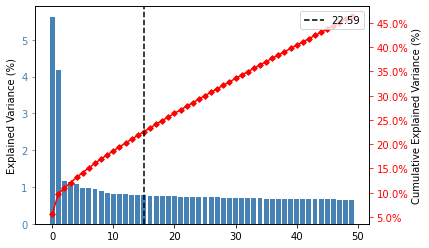

In [140]:
#plotting the total explained variance
from matplotlib.ticker import PercentFormatter

trial_npc=15

#plt.plot(np.arange(1,50+1),expl[:50]*100)


#define aesthetics for plot
color1 = 'steelblue'
color2 = 'red'
line_size = 4

#create basic bar plot
fig, ax = plt.subplots()
ax.bar(expl_df.index[0:50], expl_df['explained_variance'][0:50], color=color1)

#add cumulative percentage line to plot
ax2 = ax.twinx()
ax2.plot(expl_df.index[0:50], expl_df['cumulative_expl'][0:50], color=color2, marker="D", ms=line_size)
ax2.yaxis.set_major_formatter(PercentFormatter())

#specify axis colors
ax.tick_params(axis='y', colors=color1)
ax2.tick_params(axis='y', colors=color2)


#add labels and title

plt.xlabel("# of PCs")
ax.set_ylabel("Explained Variance (%)")
ax2.set_ylabel("Cumulative Explained Variance (%)")

plt.axvline(x = trial_npc, color = 'k',linestyle = '--',label = str(round(expl_df.cumulative_expl[trial_npc],2)))
plt.legend(loc ='upper right')

#display Pareto chart
plt.show()

In [141]:
Data_Struct['EigenVect1']=eigenVectors.real[:,0]
Data_Struct['EigenVect2']=eigenVectors.real[:,1]
Data_Struct['wEigenVect1']=eigvec_mltply_val.real[:,0]
Data_Struct['wEigenVect2']=eigvec_mltply_val.real[:,1]

print(Data_Struct.head(5))




  Sample         Population  EigenVect1  EigenVect2  EigenVect*Val1  \
0    ACP               Rest   -0.091470    0.176309        0.782583   
1    AGO               Rest   -0.077590    0.149000        0.643218   
2    AHC               Rest   -0.078437    0.160070        0.638684   
3   AM01  West_Grande_Terre   -0.025484   -0.060230        0.201552   
4   AM07  West_Grande_Terre   -0.021843   -0.081563        0.198158   

   EigenVect*Val2  wEigenVect1  wEigenVect2     tSNE1     tSNE2  tSNE1_multip  \
0       -1.096168    -0.771982     1.102331  1.438996 -5.416780      4.408365   
1       -0.918439    -0.654839     0.931590  0.723536 -6.339012      3.906428   
2       -0.979042    -0.661990     1.000797  1.116521 -6.434809      3.912755   
3        0.377945    -0.215080    -0.376576  5.199982  0.308219      4.460604   
4        0.519721    -0.184351    -0.509952  0.150328 -1.795216      3.454637   

   tSNE2_multip     UMAP1     UMAP2  UMAP1_multip  UMAP2_multip  
0      7.124754  8.1

In [142]:
# Number of principal components to use
n_pc = 15


In [145]:
eigen_vecs_real=eigenVectors.real # remeving the imaginary part of the eigen vectors
n_neighbors_num=15
mindist=0.5
# Project the eigenvectors via t-SNE to 2 dimensions.
np.random.seed(111)
proj_tsne_eig = TSNE(n_components=2).fit_transform(eigen_vecs_real[:,:n_pc])

# Project the eigenvectors via UMAPto 2 dimensions.
np.random.seed(111)
proj_umap_eig = umap.UMAP(n_components=2, n_neighbors=n_neighbors_num, min_dist=mindist).fit_transform(eigen_vecs_real[:,:n_pc])

# Project the eigenvectors*eigenvalues via t-SNE to 2 dimensions.
np.random.seed(111)
proj_tsne_eigvecval = TSNE(n_components=2).fit_transform(eigvec_mltply_val[:,:n_pc])

# Project the eigenvectors via UMAPto 2 dimensions.
np.random.seed(111)
proj_umap_eigvecval = umap.UMAP(n_components=2, n_neighbors=n_neighbors_num, min_dist=mindist).fit_transform(eigvec_mltply_val[:,:n_pc])

In [146]:
Data_Struct['tSNE1']=proj_tsne_eig[:,0]
Data_Struct['tSNE2']=proj_tsne_eig[:,1]

Data_Struct['tSNE1_multip']=proj_tsne_eigvecval[:,0]
Data_Struct['tSNE2_multip']=proj_tsne_eigvecval[:,1]

Data_Struct['UMAP1']=proj_umap_eig[:,0]
Data_Struct['UMAP2']=proj_umap_eig[:,1]

Data_Struct['UMAP1_multip']=proj_umap_eigvecval[:,0]
Data_Struct['UMAP2_multip']=proj_umap_eigvecval[:,1]

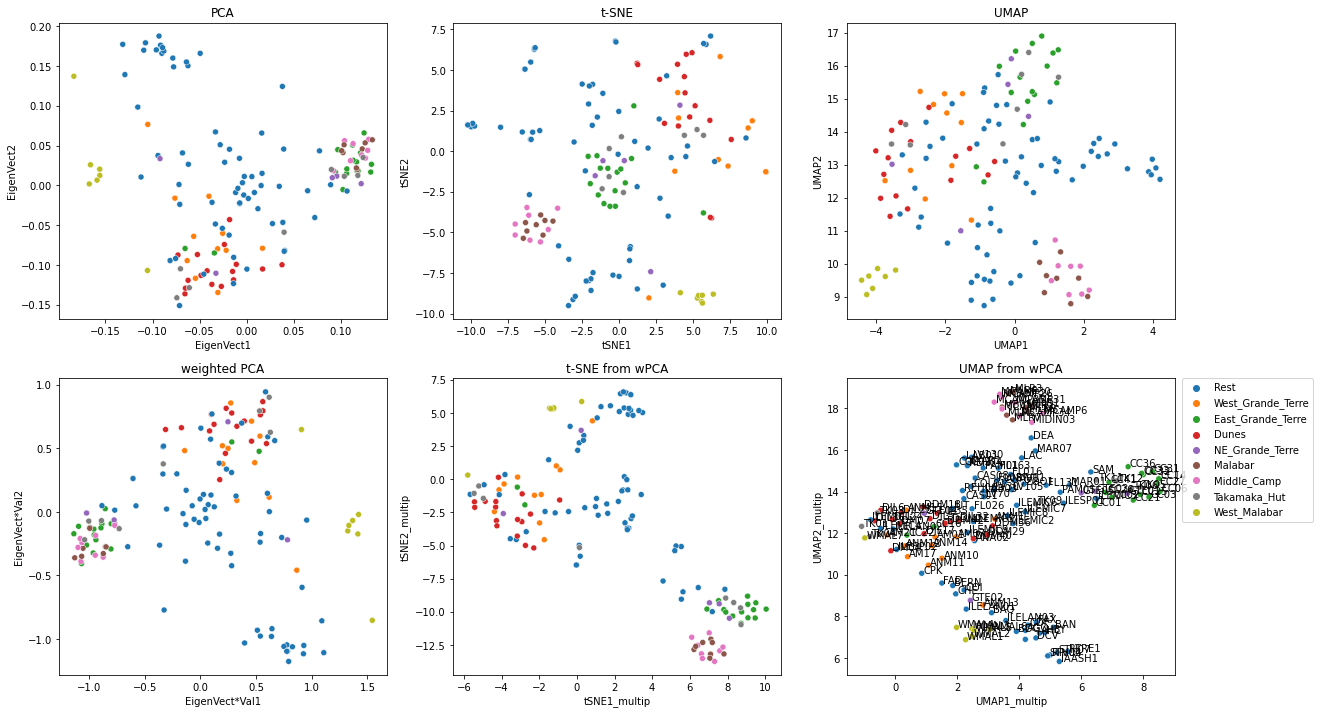

In [147]:
fig, axs = plt.subplots(2, 3,figsize=(20, 12))

#axs[1,1] = Data_Struct.plot.scatter(x='X1',y='X2',c='Population')

sns.scatterplot(ax=axs[0,0],data=Data_Struct, x='EigenVect1', y='EigenVect2', hue='Population',legend = False).set(title='PCA')
sns.scatterplot(ax=axs[0,1],data=Data_Struct, x='tSNE1', y='tSNE2', hue='Population',legend = False).set(title='t-SNE')
sns.scatterplot(ax=axs[0,2],data=Data_Struct, x='UMAP1', y='UMAP2', hue='Population',legend = False).set(title='UMAP')
#plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

sns.scatterplot(ax=axs[1,0],data=Data_Struct, x='EigenVect*Val1', y='EigenVect*Val2', hue='Population',legend = False).set(title='weighted PCA')
sns.scatterplot(ax=axs[1,1],data=Data_Struct, x='tSNE1_multip', y='tSNE2_multip', hue='Population',legend = False).set(title='t-SNE from wPCA')
sns.scatterplot(ax=axs[1,2],data=Data_Struct, x='UMAP1_multip', y='UMAP2_multip', hue='Population').set(title='UMAP from wPCA')
for i in range(1,143):
    plt.text(x=Data_Struct['UMAP1_multip'][i]+0.05, y=Data_Struct['UMAP2_multip'][i],s=Data_Struct['Sample'][i])
    
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
